# Statistical Arbitrage - Pairs Trading

In [1]:
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [20]:
# Get paths to the NIFTY100 stock csv files
stock_data_paths = glob.glob('/Users/rshah181/Desktop/AMADEUS/NIFTY100/*')

# Extract stock tickers from the stock_data_paths list
stock_tickers = list(
    pd.Series(stock_data_paths).apply(
        lambda x: x.split('/')[-1].split('.')[0]))

# List to store tickers of stocks with insufficient data
failed_tickers = []

# DataFrame to store closing prices of the stocks
master_price_data = pd.DataFrame()

# Iterate over the tickers
for ticker in stock_tickers:

    # Read price data CSV of the selected ticker
    price_data = pd.read_csv('/Users/rshah181/Desktop/AMADEUS/NIFTY100/' +
                             ticker + '.csv')

    # Check if the # of rows is less thatn 3500
    if len(price_data) < 3500:
        failed_tickers.append(ticker)
        continue

    # Clean up price data and set datetimec column as index
    price_data['datetime'] = price_data['datetime'].apply(
        lambda x: datetime.datetime.strptime(x.split()[0], '%Y-%m-%d'))
    price_data = price_data.set_index('datetime')
    price_data = price_data.dropna()

    # Store close prices in a variable called close
    close = price_data['close']

    # Resample close prices to daily timeframe to remove any timestamp duplicates
    close = close.resample('D').first()

    # Add close prices of the ticker to master_price_data
    master_price_data[ticker] = close

# Replace 0s with NAs and drop rows with NAs
master_price_data = master_price_data.replace(0, np.nan).dropna()

# Split into in sample, validation and out sample sets
in_sample = master_price_data.iloc[:int(len(master_price_data) / 3)]
validation = master_price_data.iloc[int(len(master_price_data) /
                                        3):int(len(master_price_data) / 2)]
out_sample = master_price_data.iloc[int(len(master_price_data) / 2):]

In [159]:
stock_data = in_sample.copy()

In [160]:
stock_data

,BHARTIARTL,TATASTEEL,LUPIN,BOSCHLTD,TITAN,PETRONET,GODREJCP,BRITANNIA,RELINFRA,BANKBARODA,...,DIVISLAB,BAJAJHLDNG,SBIN,CADILAHC,IDFC,INDUSINDBK,PEL,CORPBANK,BAJFINANCE,MCDOWELL-N
datetime,,,,,,,,,,,,,,,,,,,,,
2005-10-19,156.38,319.54,73.94,2410.60,21.68,29.58,36.30,117.62,512.10,45.08,...,70.80,640.31,83.89,29.71,31.57,56.20,264.60,70.21,28.88,89.04
2005-10-20,157.35,316.93,73.50,2386.60,20.95,29.18,35.67,113.99,522.25,42.50,...,69.62,634.89,81.93,29.13,30.42,53.35,252.90,70.07,27.44,85.48
2005-10-21,165.55,324.71,73.47,2364.90,22.36,28.38,37.17,117.49,538.10,43.51,...,69.08,640.75,83.65,28.80,31.62,55.45,235.35,70.09,27.88,90.24
2005-10-24,161.88,311.37,72.04,2350.40,21.31,29.43,37.93,118.83,531.60,43.43,...,65.94,663.03,81.54,29.84,31.38,53.75,234.30,69.29,28.07,86.88
2005-10-25,164.78,309.77,70.52,2355.65,21.34,29.40,37.89,117.29,532.25,44.57,...,64.83,661.43,83.49,28.58,31.69,52.80,232.80,69.44,27.76,84.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-02,318.05,547.25,380.97,5679.10,140.85,46.15,117.23,208.96,1116.60,152.64,...,378.38,727.85,258.63,125.86,91.60,205.20,485.95,115.15,55.83,281.31
2010-08-03,328.45,547.00,384.23,5647.35,140.89,48.90,116.33,211.98,1120.90,155.59,...,377.23,726.00,260.06,125.62,90.70,211.20,479.85,114.93,55.33,286.35
2010-08-04,323.15,540.55,383.66,5690.60,140.44,49.55,115.25,217.20,1140.15,154.07,...,377.43,716.60,259.51,128.88,91.33,207.85,472.00,115.11,56.39,288.07


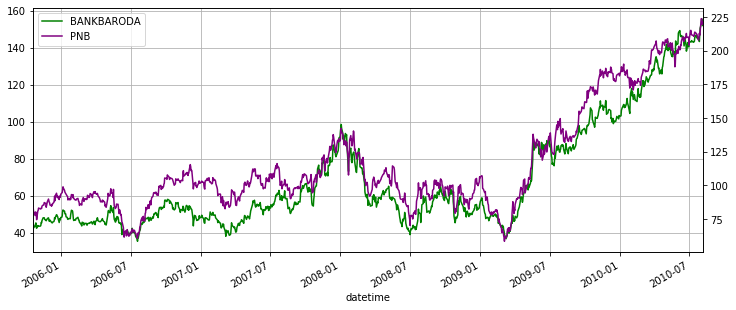

In [161]:
plt.figure(figsize=(12, 5))
ax1 = stock_data['BANKBARODA'].plot(color='green',
                                    grid=True,
                                    label='BANKBARODA')
ax2 = stock_data['PNB'].plot(color='purple',
                             grid=True,
                             secondary_y=True,
                             label='PNB')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2, loc=2)
plt.show()

In [162]:
def normalize_and_accumulate_series(data):
    # take tail to drop head NA
    return data.pct_change().cumsum()


for col in stock_data.columns:

    stock_data[col] = normalize_and_accumulate_series(stock_data[col])

# remove first row with NAs
stock_data = stock_data.tail(len(stock_data) - 1)

In [163]:
stock_data

,BHARTIARTL,TATASTEEL,LUPIN,BOSCHLTD,TITAN,PETRONET,GODREJCP,BRITANNIA,RELINFRA,BANKBARODA,...,DIVISLAB,BAJAJHLDNG,SBIN,CADILAHC,IDFC,INDUSINDBK,PEL,CORPBANK,BAJFINANCE,MCDOWELL-N
datetime,,,,,,,,,,,,,,,,,,,,,
2005-10-20,0.006203,-0.008168,-0.005951,-0.009956,-0.033672,-0.013523,-0.017355,-0.030862,0.019820,-0.057232,...,-0.016667,-0.008465,-0.023364,-0.019522,-0.036427,-0.050712,-0.044218,-0.001994,-0.049861,-0.039982
2005-10-21,0.058316,0.016380,-0.006359,-0.019048,0.033632,-0.040939,0.024697,-0.000158,0.050170,-0.033467,...,-0.024423,0.000765,-0.002370,-0.030851,0.003021,-0.011349,-0.113613,-0.001709,-0.033827,0.015704
2005-10-24,0.036147,-0.024703,-0.025823,-0.025180,-0.013327,-0.003941,0.045143,0.011248,0.038090,-0.035306,...,-0.069878,0.035537,-0.027595,0.005261,-0.004569,-0.042007,-0.118074,-0.013122,-0.027012,-0.021531
2005-10-25,0.054062,-0.029841,-0.046922,-0.022946,-0.011920,-0.004960,0.044089,-0.001712,0.039313,-0.009056,...,-0.086711,0.033124,-0.003680,-0.036965,0.005310,-0.059682,-0.124476,-0.010958,-0.038055,-0.053759
2005-10-26,0.075909,-0.040107,-0.058975,-0.025705,-0.018949,-0.006661,0.044089,-0.028228,0.021934,0.007322,...,-0.063574,0.017733,-0.003919,-0.036615,-0.004473,-0.099454,-0.128772,-0.013550,-0.026168,-0.019030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-02,1.146227,1.295244,1.969612,1.118226,2.477752,0.999356,1.496953,0.764463,1.679595,1.724006,...,2.184902,0.633015,1.571248,1.722455,1.870065,2.226795,1.105106,0.959785,1.390057,1.935247
2010-08-03,1.178926,1.294787,1.978169,1.112635,2.478036,1.058944,1.489275,0.778915,1.683446,1.743332,...,2.181863,0.630473,1.576777,1.720548,1.860240,2.256034,1.092553,0.957874,1.381101,1.953163
2010-08-04,1.162790,1.282996,1.976685,1.120294,2.474842,1.072237,1.479992,0.803540,1.700620,1.733563,...,2.182393,0.617525,1.574663,1.746499,1.867186,2.240173,1.076194,0.959440,1.400259,1.959170


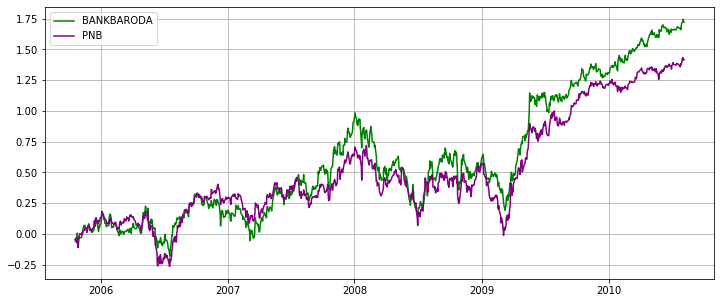

In [164]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(stock_data['BANKBARODA'], color='green', label='BANKBARODA')
plt.plot(stock_data['PNB'], color='purple', label='PNB')
ax.grid(True)
plt.legend(loc=2)
plt.show()

In [165]:
# pip install scipy
# pip install statsmodels
from statsmodels.tsa.stattools import coint

In [211]:
stock_data[stock_name_1]

datetime
2005-10-20   -0.057232
2005-10-21    0.023765
2005-10-24   -0.001839
2005-10-25    0.026249
2005-10-26    0.016379
                ...   
2010-08-02    0.014421
2010-08-03    0.019327
2010-08-04   -0.009769
2010-08-05   -0.003375
2010-08-06   -0.010615
Name: BANKBARODA, Length: 1182, dtype: float64

In [166]:
stock_name_1 = 'BANKBARODA'
stock_name_2 = 'PNB'

score, pvalue, _ = coint(stock_data[stock_name_1], stock_data[stock_name_2])
correlation = (stock_data[[stock_name_1, stock_name_2]]).corr().iloc[1, 0]

print('Correlation between %s and %s is %f' %
      (stock_name_1, stock_name_2, correlation))
print('Cointegration between %s and %s is %f' %
      (stock_name_1, stock_name_2, pvalue))

Correlation between BANKBARODA and PNB is 0.983055
Cointegration between BANKBARODA and PNB is 0.024553


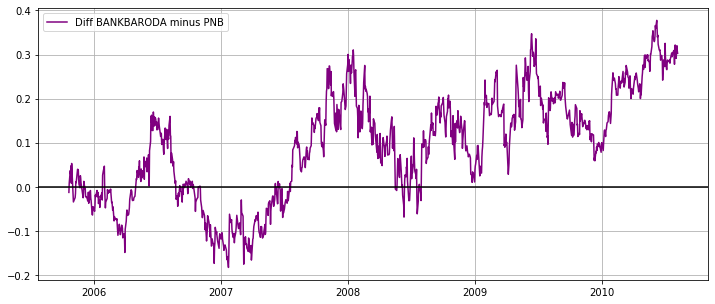

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['BANKBARODA'] - stock_data['PNB'], color='purple', label='Diff BANKBARODA minus PNB')
ax.grid(True)
ax.axhline(y=0, color='black', linestyle='-') 
plt.legend(loc=2)
plt.show()

In [168]:
# get the original data set
stock_data = in_sample.copy()

In [169]:
def normalize_series(data):
    
    return data.pct_change()

for col in stock_data.columns:
    
    stock_data[col] = normalize_series(stock_data[col])

# remove first row with NAs 
stock_data = stock_data.tail(len(stock_data)-1)

In [170]:
stock_name_1 = 'BANKBARODA'
stock_name_2 = 'PNB'

score, pvalue, _ = coint(stock_data[stock_name_1], stock_data[stock_name_2])
correlation = (stock_data[[stock_name_1, stock_name_2]]).corr().iloc[1, 0]

print('Correlation between %s and %s is %f' %
      (stock_name_1, stock_name_2, correlation))
print('Cointegration between %s and %s is %f' %
      (stock_name_1, stock_name_2, pvalue))

Correlation between BANKBARODA and PNB is 0.678498
Cointegration between BANKBARODA and PNB is 0.000000


In [58]:
stock_data.head()

,BHARTIARTL,TATASTEEL,LUPIN,BOSCHLTD,TITAN,PETRONET,GODREJCP,BRITANNIA,RELINFRA,BANKBARODA,...,DIVISLAB,BAJAJHLDNG,SBIN,CADILAHC,IDFC,INDUSINDBK,PEL,CORPBANK,BAJFINANCE,MCDOWELL-N
datetime,,,,,,,,,,,,,,,,,,,,,
2005-10-20,0.006203,-0.008168,-0.005951,-0.009956,-0.033672,-0.013523,-0.017355,-0.030862,0.019820,-0.057232,...,-0.016667,-0.008465,-0.023364,-0.019522,-0.036427,-0.050712,-0.044218,-0.001994,-0.049861,-0.039982
2005-10-21,0.052113,0.024548,-0.000408,-0.009092,0.067303,-0.027416,0.042052,0.030704,0.030349,0.023765,...,-0.007756,0.009230,0.020994,-0.011329,0.039448,0.039363,-0.069395,0.000285,0.016035,0.055686
2005-10-24,-0.022169,-0.041083,-0.019464,-0.006131,-0.046959,0.036998,0.020447,0.011405,-0.012080,-0.001839,...,-0.045455,0.034772,-0.025224,0.036111,-0.007590,-0.030658,-0.004461,-0.011414,0.006815,-0.037234
2005-10-25,0.017915,-0.005139,-0.021099,0.002234,0.001408,-0.001019,-0.001055,-0.012960,0.001223,0.026249,...,-0.016833,-0.002413,0.023915,-0.042225,0.009879,-0.017674,-0.006402,0.002165,-0.011044,-0.032228
2005-10-26,0.021847,-0.010266,-0.012053,-0.002759,-0.007029,-0.001701,0.000000,-0.026515,-0.017379,0.016379,...,0.023137,-0.015391,-0.000240,0.000350,-0.009782,-0.039773,-0.004296,-0.002592,0.011888,0.034729


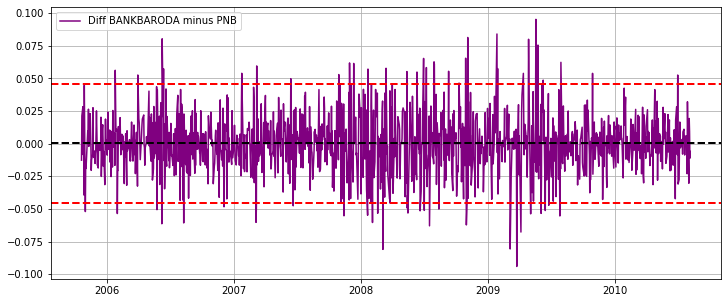

In [59]:
fig, ax = plt.subplots(figsize=(12, 5))
diff = stock_data['BANKBARODA'] - stock_data['PNB']
plt.plot(diff, color='purple', label='Diff BANKBARODA minus PNB')
ax.grid(True)
plt.axhline(diff.mean(), ls='--', color='black', lw=2)
plt.axhline(diff.mean() + diff.std() * 2, ls='--', color='r', lw=2)
plt.axhline(diff.mean() - diff.std() * 2, ls='--', color='r', lw=2)
plt.legend(loc=2)
plt.show()

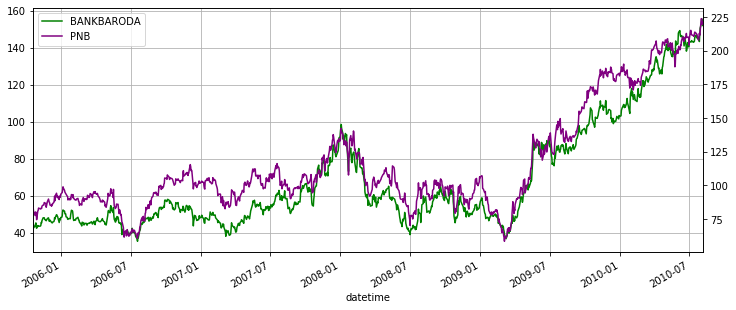

In [161]:
plt.figure(figsize=(12, 5))
ax1 = stock_data['BANKBARODA'].plot(color='green',
                                    grid=True,
                                    label='BANKBARODA')
ax2 = stock_data['PNB'].plot(color='purple',
                             grid=True,
                             secondary_y=True,
                             label='PNB')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1 + h2, l1 + l2, loc=2)
plt.show()

In [174]:
diff = stock_data['BANKBARODA'] - stock_data['PNB']

In [175]:
strat = in_sample[['BANKBARODA', 'PNB']]
strat['spread'] = diff
strat.dropna(inplace = True)

spread = BB - PNB

spread > 0 => BB > PNB

spread < 0 => BB < PNB


In [176]:
strat

,BANKBARODA,PNB,spread
datetime,,,
2005-10-20,42.50,79.72,-0.012649
2005-10-21,43.51,79.92,0.021256
2005-10-24,43.43,77.51,0.028316
2005-10-25,44.57,80.20,-0.008456
2005-10-26,45.30,79.98,0.019122
...,...,...,...
2010-08-02,152.64,223.67,-0.030326
2010-08-03,155.59,223.68,0.019282
2010-08-04,154.07,219.41,0.009321


In [177]:
# Import RSI from pyti
from pyti.relative_strength_index import relative_strength_index as calc_rsi

In [199]:
# Compute 20-period RSI values of the spread
strat['rsi'] = calc_rsi(strat['spread'], 14)

# Compute buy points and sell points based on the RSI
strat['buy'] = strat[strat['rsi'] < 45]['spread']
strat['sell'] = strat[strat['rsi'] > 55]['spread']

In [200]:
strat

,BANKBARODA,PNB,spread,rsi,buy,sell
datetime,,,,,,
2005-10-20,42.50,79.72,-0.012649,NaN,NaN,NaN
2005-10-21,43.51,79.92,0.021256,NaN,NaN,NaN
2005-10-24,43.43,77.51,0.028316,NaN,NaN,NaN
2005-10-25,44.57,80.20,-0.008456,NaN,NaN,NaN
2005-10-26,45.30,79.98,0.019122,NaN,NaN,NaN
...,...,...,...,...,...,...
2010-08-02,152.64,223.67,-0.030326,43.840530,-0.030326,NaN
2010-08-03,155.59,223.68,0.019282,53.364876,NaN,NaN
2010-08-04,154.07,219.41,0.009321,51.476990,NaN,NaN


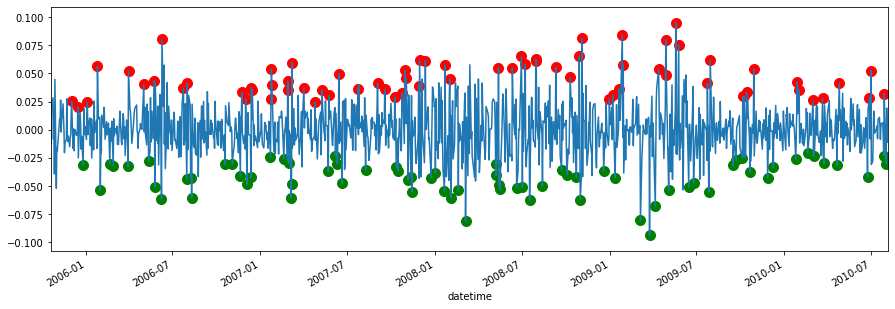

In [201]:
# Plot the buy and sell points on the spread
strat['spread'].iloc[:].plot(figsize=(15, 5))
plt.scatter(strat.index, strat['buy'], c='g', s=100)
plt.scatter(strat.index, strat['sell'], c='r', s=100)

spread = BB - PNB

spread > 0 => BB > PNB - Buy PNB, Sell BB

spread < 0 => BB < PNB - Sell PNB, Buy BB


In [206]:
# Convert buy and sell points into integers (1, 0)
strat['buy']= (abs(strat['buy']) > 0).apply(int)
strat['sell'] = (abs(strat['sell']) > 0).apply(int)

# Create a column naming the "perspective" ticker
strat['who?'] = 'BANKBARODA'

In [210]:
strat[(strat['buy'] == 1) | (strat['sell'] == 1)].head(20)

,BANKBARODA,PNB,spread,rsi,buy,sell,who?
datetime,,,,,,,
2005-12-02,46.80,85.32,0.025104,55.405585,0,1,BANKBARODA
2005-12-15,47.40,88.51,0.020262,55.213468,0,1,BANKBARODA
2005-12-26,45.49,89.41,-0.031411,44.485376,1,0,BANKBARODA
2006-01-04,51.47,96.88,0.024179,55.177432,0,1,BANKBARODA
2006-01-25,49.66,89.45,0.056198,58.280306,0,1,BANKBARODA
2006-01-31,49.96,93.07,-0.053528,42.404395,1,0,BANKBARODA
2006-02-20,44.90,86.20,-0.030620,44.307329,1,0,BANKBARODA
2006-02-27,45.42,90.92,-0.031905,44.586366,1,0,BANKBARODA
2006-03-30,44.35,95.31,-0.032530,43.382099,1,0,BANKBARODA


***